# Dataset Overview
Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.

Natural Classes: 5 
- business 
- entertainment 
- politics 
- sport
- tech

There seems to be 2 separate folders but with same data. Ignored the second folder.

Documents corresponding to classes are inside respective folder names

Each class has around 400-500 documents in it


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

# os.listdir('/kaggle/input/bbc-full-text-document-classification')
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    count = 0
    for filename in filenames:
        if count > 5:
            break
        print(os.path.join(dirname, filename))
        count += 1

/kaggle/input
/kaggle/input/bbc-full-text-document-classification
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/README.TXT
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/business
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/business/189.txt
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/business/203.txt
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/business/309.txt
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/business/372.txt
/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)

In [2]:
# check if both files are same
!diff '/kaggle/input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/tech/128.txt' '/kaggle/input/bbc-full-text-document-classification/bbc/tech/128.txt'

In [3]:
data_dir = '/kaggle/input/bbc-full-text-document-classification/bbc'
os.listdir(data_dir)

['README.TXT', 'business', 'tech', 'sport', 'entertainment', 'politics']

In [4]:
!cat {data_dir}/README.TXT

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html



### Reading data into Dataframes for easy overview of data and subsequent processing

In [5]:
from collections import defaultdict
frame = defaultdict(list)

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        frame['category'].append(os.path.basename(dirname))
        
        name = os.path.splitext(filename)[0]
        frame['document_id'].append(name)

        path = os.path.join(dirname, filename)
        # throwed UnicodeDecodeError without encoding
        # Googled "UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3" - https://stackoverflow.com/a/55391198/7445772
        with open(path ,'r', encoding= 'unicode_escape') as file:
            frame['text'].append(file.read())


In [6]:
df = pd.DataFrame.from_dict(frame)

In [7]:
df.head(3)

,category,document_id,text
0,bbc,README,Consists of 2225 documents from the BBC news w...
1,business,189,Fiat chief takes steering wheel\n\nThe chief e...
2,business,203,'Standoff' on Deutsche's LSE bid\n\nDeutsche B...


### Exploring Data

In [8]:
df['category'].value_counts()
# bbc is data_dir with just readme file, we can drop it and proceed

sport            511
business         510
politics         417
tech             401
entertainment    386
bbc                1
Name: category, dtype: int64

In [9]:
df.drop(0, axis=0, inplace=True)

In [10]:
len(df['document_id'].unique())

511

In [11]:
# seems like incremental numbers for document names 
sorted_ids = sorted(df['document_id'].unique())
print(sorted_ids[:10], sorted_ids[-10:])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'] ['502', '503', '504', '505', '506', '507', '508', '509', '510', '511']


In [12]:
import random

num = 5
sample = random.sample(range(df.text.shape[0]), num)

for idx in sample:
    print('*'*30)
    values = df.iloc[idx]
    print('Document ID : ', values['document_id'])
    print('Category : ', values['category'])
    print('Text : \n'+'-'*7)
    print(values['text'])
    print('='*36)

******************************
Document ID :  307
Category :  sport
Text : 
-------
Wales critical of clumsy Grewcock

Wales coach Mike Ruddock says England lock Danny Grewcock needs to review his actions after he kicked Dwayne Peel.

Trouble flared at a ruck in the first half of Wales' 11-9 win in Cardiff as Grewcock came recklessly over the top with his boot, leaving Peel bloodied. Grewcock was sin-binned with Wales captain Gareth Thomas for retaliation. "It's up to the citing commissioner," said Ruddock. "I'm not saying it's deliberate, but Grewcock did a similar thing for Bath against Leinster." Last June Grewcock was banned from rugby for two months for reckless use of a boot in a match against New Zealand.

Six years earlier, also in New Zealand, Grewcock became only the second England player to be sent off in Tests. The player himself and his captain Jason Robinson have both said that the clash with Peel was accidental. "If the ball is at the back of the ruck and I feel I can st

On brief observation we can see that first line of text seems to be title and the next part is story/news article

- We can split the text column into 2 separate features title and story
- We can see there are financial symbols, punctuation marks, many stop words, new lines and some words like - "doesn't", "didn't" inside the text. These has to be taken care during preprocessing


In [13]:
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/
text = df["text"].str.split("\n", n = 1, expand = True) 

df["title"] =  text[0]
df['story'] = text[1]

In [14]:
df.head()

,category,document_id,text,title,story
1,business,189,Fiat chief takes steering wheel\n\nThe chief e...,Fiat chief takes steering wheel,\nThe chief executive of the Fiat conglomerate...
2,business,203,'Standoff' on Deutsche's LSE bid\n\nDeutsche B...,'Standoff' on Deutsche's LSE bid,\nDeutsche Boerse investors unhappy with its L...
3,business,309,AstraZeneca hit by drug failure\n\nShares in A...,AstraZeneca hit by drug failure,\nShares in Anglo-Swedish drug have closed dow...
4,business,372,Madagascar completes currency switch\n\nMadaga...,Madagascar completes currency switch,\nMadagascar has completed the replacement of ...
5,business,111,Unilever shake up as profit slips\n\nAnglo-Dut...,Unilever shake up as profit slips,\nAnglo-Dutch consumer goods giant Unilever is...


In [15]:
for idx in sample[:2]:
    print('*'*30)
    values = df.iloc[idx]
    print('Document ID : ', values['document_id'])
    print('Category : ', values['category'])
    print('Title : \n'+'-'*9)
    print(values['title'])
    print('\nStory : \n'+'-'*9)
    print(values['story'])
    print('='*36)

******************************
Document ID :  307
Category :  sport
Title : 
---------
Wales critical of clumsy Grewcock

Story : 
---------

Wales coach Mike Ruddock says England lock Danny Grewcock needs to review his actions after he kicked Dwayne Peel.

Trouble flared at a ruck in the first half of Wales' 11-9 win in Cardiff as Grewcock came recklessly over the top with his boot, leaving Peel bloodied. Grewcock was sin-binned with Wales captain Gareth Thomas for retaliation. "It's up to the citing commissioner," said Ruddock. "I'm not saying it's deliberate, but Grewcock did a similar thing for Bath against Leinster." Last June Grewcock was banned from rugby for two months for reckless use of a boot in a match against New Zealand.

Six years earlier, also in New Zealand, Grewcock became only the second England player to be sent off in Tests. The player himself and his captain Jason Robinson have both said that the clash with Peel was accidental. "If the ball is at the back of the r

### Data Ananlysis

#### Univariate Analysis - Category

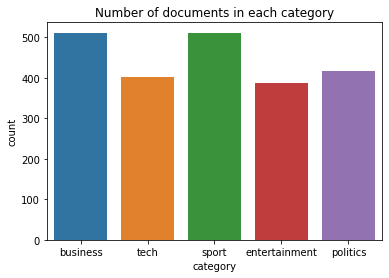

In [16]:
sns.countplot(df.category)
plt.title('Number of documents in each category')
plt.show()

#### Univariate Analysis - Title

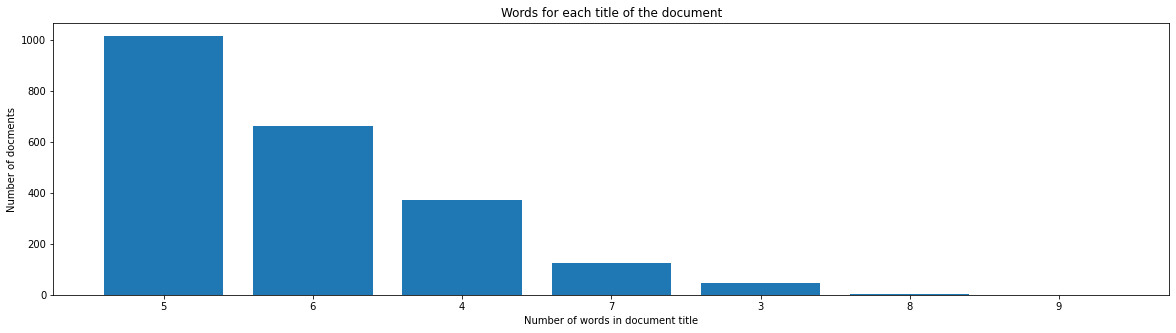

In [17]:
# Googled "How to calculate number of words in a string in DataFrame" - https://stackoverflow.com/a/37483537/4084039

word_dict = dict(df['title'].str.split().apply(len).value_counts())

idx = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(idx, list(word_dict.values()))

plt.ylabel('Number of docments')
plt.xlabel('Number of words in document title')
plt.title('Words for each title of the document')
plt.xticks(idx, list(word_dict.keys()))
plt.show()

- Lot of project titles have 4-6 word count, while there are very insignificant no. of projects with title that has word count 3 or 7 to 9.

In [18]:
cat_titles_word_count = defaultdict(list)
for category in df.category.unique():
    val = df[df['category']==category]['title'].str.split().apply(len).values
    cat_titles_word_count[category]=val

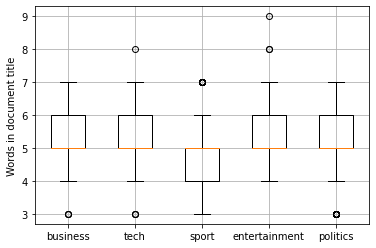

In [19]:
# distribution of titles across categories
plt.boxplot(cat_titles_word_count.values())
keys = cat_titles_word_count.keys()
plt.xticks([i+1 for i in range(len(keys))], keys)
plt.ylabel('Words in document title')
plt.grid()
plt.show()

- Mean of title word count is 5 for all categories
- Sports category titles seems to have smaller titles
- All categories except for sports have 25%le to 75%le between 4 to 7

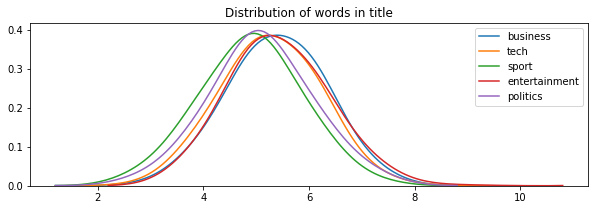

In [20]:
# distribution of words in title
plt.figure(figsize=(10,3))
for key, value in cat_titles_word_count.items():
    sns.kdeplot(value,label=key, bw=0.6)
plt.legend()
plt.title('Distribution of words in title')
plt.show()

#### Univariate Analysis - Story

In [21]:
category_story_word_count = defaultdict(list)
for category in df.category.unique():
    val = df[df['category']==category]['story'].str.split().apply(len).values
    category_story_word_count[category]=val

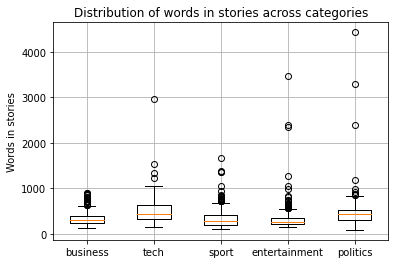

In [22]:
# distribution of stories across categories
plt.boxplot(category_story_word_count.values())
plt.title('Distribution of words in stories across categories')
keys = category_story_word_count.keys()
plt.xticks([i+1 for i in range(len(keys))], keys)
plt.ylabel('Words in stories')
plt.grid()
plt.show()

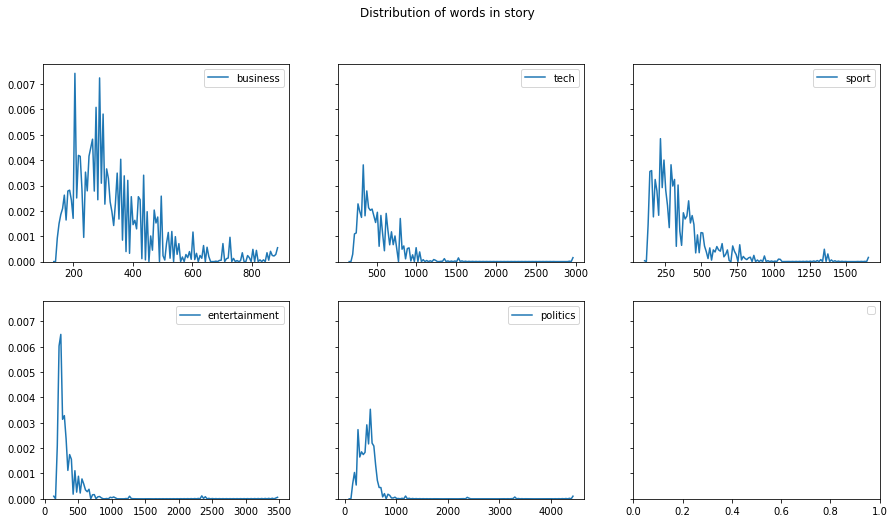

In [23]:
# distribution of words in story
fig, axes = plt.subplots(2, 3, figsize=(15,8), sharey=True)
ax = axes.flatten()
plt.suptitle('Distribution of words in story')

for idx, (key, value) in enumerate(category_story_word_count.items()):
    sns.kdeplot(value,label=key, bw=0.6, ax=ax[idx])
plt.legend()
plt.show()

## Preprocessing

### Title - Text preprocessing

In [24]:
# printing random titles
samples = random.sample(range(len(df.title)), 10)
for idx in samples:
    print(df.title[idx])
    print('-'*36)

BMW drives record sales in Asia
------------------------------------
Blair congratulates Bush on win
------------------------------------
'Post-Christmas lull' in lending
------------------------------------
J&J agrees $25bn Guidant deal
------------------------------------
Henman decides to quit Davis Cup
------------------------------------
Wales 'must learn health lessons'
------------------------------------
Lennon brands Rangers favourites
------------------------------------
Palace threat over Cantona masks
------------------------------------
Mobile TV tipped as one to watch
------------------------------------
Halo fans' hope for sequel
------------------------------------


In [25]:
# stop words
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [26]:
import re

def clean_text(text):
    # decontraction : https://stackoverflow.com/a/47091490/7445772
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # remove line breaks \r \n \t remove from string 
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\t', ' ')
    text = text.replace('\\n', ' ')

    # remove stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)

    # remove special chars
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower()
    return text

In [27]:
from tqdm import tqdm

In [28]:
processed_titles = []
for title in tqdm(df['title'].values):
    processed_title = clean_text(title)
    processed_titles.append(processed_title)

100%|██████████| 2225/2225 [00:00<00:00, 23026.80it/s]


In [29]:
# titles after processing
for idx in samples:
    print(processed_titles[idx])
    print('-'*36)

singapore growth 8 1 2004
------------------------------------
new foot mouth action urged
------------------------------------
us retail sales surge december
------------------------------------
us airways staff agree pay cut
------------------------------------
edgy agassi struggles past dent
------------------------------------
schools take part mock poll
------------------------------------
dominici backs lacklustre france
------------------------------------
mirza shocks kuznetsova
------------------------------------
software watching work
------------------------------------
microsoft debuts security tools
------------------------------------


### Story - Text preprocessing

In [30]:
for idx in samples[:2]:
    print(df.story[idx])
    print('-'*36)


BMW has forecast sales growth of at least 10% in Asia this year after registering record sales there in 2004.

The luxury carmaker saw strong sales of its three marques - BMW, Mini and Rolls-Royce - in Asia last year after the launch of three new models. The company, which is vying with Mercedes-Benz for the title of leading premium carmaker, is confident about its prospects for the region in 2005. It is launching a revamped version of its 3-Series saloon class next month.

BMW sold nearly 95,000 cars in Asia last year, up 2.6% on 2003.

BMW-brand sales rose 2.3% to 80,600 while sales of Mini models rose 3.6% to 14,800. There was also a significant increase in sales of Rolls-Royces on the continent. BMW sold more than 100 of the iconic models compared with just ten the previous year. The German carmaker is aiming to boost annual sales in Asia to 150,000 by 2008. "Here in Asia, we consider a double-digit increase in retail on the order of 10 to 15% to be realistic on the basis of curre

In [31]:
processed_stories = []
for story in tqdm(df['story'].values):
    processed_story = clean_text(story)
    processed_stories.append(processed_story)

100%|██████████| 2225/2225 [00:02<00:00, 871.57it/s]


In [32]:
for i in range(5):
    print(df.category.values[i])
    print(processed_titles[i])
    print(processed_stories[i])
    print('-'*100)

business
fiat chief takes steering wheel
the chief executive fiat conglomerate taken day to day control struggling car business effort turn around sergio marchionne replaced herbert demel chief executive fiat auto mr demel leaving company mr marchionne becomes fourth head business expected make 800m euro 1bn loss 2004 many years fiat underperformed market europe last year seeing flat sales the car business made operating loss five last six years forced push back break even target 2005 2006 the management changes part wider shake up business following fiat resolution dispute general motors as part major restructuring fiat integrate maserati car company currently owned ferrari within operations ferrari fiat owns majority stake could separately floated stock market either 2006 2007 mr marchionne joined company last year said fiat auto principal focus attention i made decision take post chief executive auto unit speed company recovery said a profound cultural transformation underway follow

### Preparing data for models

#### Vectorizing Text data

#### Title - Bag of Words (BoW)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [34]:
# considering only the words which appeared in at least 5 document titles.
vectorizer = CountVectorizer(min_df=5)
title_bow = vectorizer.fit_transform(processed_titles)
print("Shape after one hot encodig ",title_bow.shape)

Shape after one hot encodig  (2225, 503)


#### Title - TFIDF

In [35]:
vectorizer = TfidfVectorizer(min_df=5)
title_tfidf = vectorizer.fit_transform(processed_titles)
print("Shape after one hot encodig ",title_tfidf.shape)

Shape after one hot encodig  (2225, 503)


#### Title - TFIDF n-gram

In [36]:
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range =(1, 2),max_features = 750, min_df=5)
title_tfidf_ngram = vectorizer.fit_transform(processed_titles)
print("Shape after one hot encodig ",title_tfidf_ngram.shape)


Shape after one hot encodig  (2225, 519)


#### Story/Document - Bag of Words (BoW)

In [37]:
# considering only the words which appeared in at least 10 document.
vectorizer = CountVectorizer(min_df=10)
story_bow = vectorizer.fit_transform(processed_stories)
print("Shape after one hot encodig ",story_bow.shape)

Shape after one hot encodig  (2225, 5787)


#### Story/Document - TFIDF

In [38]:
vectorizer = TfidfVectorizer(min_df=10)
story_tfidf = vectorizer.fit_transform(processed_stories)
print("Shape after one hot encodig ",story_tfidf.shape)

Shape after one hot encodig  (2225, 5787)


In [39]:
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range =(1, 4),max_features = 7500, min_df=10)
story_tfidf_ngram = vectorizer.fit_transform(processed_stories)
print("Shape after one hot encodig ",story_tfidf_ngram.shape)


Shape after one hot encodig  (2225, 7500)


##### Vectorizing Categorical data - Target feature

In [40]:
vectorizer = LabelEncoder()
category_onehot = vectorizer.fit_transform(df['category'].values)
# print(vectorizer.get_feature_names())

print("Shape after one hot encoding : ",category_onehot.shape)

Shape after one hot encoding :  (2225,)


### Model input
- Merging the features
- preparing target

In [41]:
from scipy.sparse import hstack

In [42]:
X_bow = hstack((title_bow, story_bow))
X_tfidf =  hstack((title_tfidf, story_tfidf))
X_ngram = hstack((title_tfidf_ngram, story_tfidf_ngram))
print(X_bow.shape, X_tfidf.shape, X_ngram.shape)

(2225, 6290) (2225, 6290) (2225, 8019)


In [43]:
print(type(category_onehot), type(X_bow))

<class 'numpy.ndarray'> <class 'scipy.sparse.coo.coo_matrix'>


## Data Modeling

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import linear_model, naive_bayes, svm

In [55]:
labels = ['tech', 'sport', 'business', 'entertainment', 'politics']
def show_confusion_matrix(prediction, y_test, labels = labels):
    # https://stackoverflow.com/a/48018785/7445772 
    idx = [i for i in range(len(labels))]
    cm = confusion_matrix(y_test, prediction, idx)
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels, rotation=45); 
    ax.yaxis.set_ticklabels(labels[::-1], rotation=45);
    plt.title('Confusion matrix of the classifier')
    plt.show()


### Using BOW vectors

In [46]:
X = X_bow.toarray()
y = category_onehot
print(X.shape, y.shape)

(2225, 6290) (2225,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=9)

model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
LR_prediction = model.predict(X_test)

model = naive_bayes.MultinomialNB()
model.fit(X_train,y_train)
NB_prediction = model.predict(X_test)

model = svm.SVC()
model.fit(X_train,y_train)
SVM_prediction = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy with BOW vectors 
---------------
Using Logistic regression : 0.9685393258426966
Using Naive Bayes : 0.9595505617977528
Using Support Vector Machines : 0.952808988764045
[[93  0  5  0  1]
 [ 0 79  0  0  0]
 [ 2  0 86  0  0]
 [ 0  0  0 85  0]
 [ 4  2  0  0 88]]


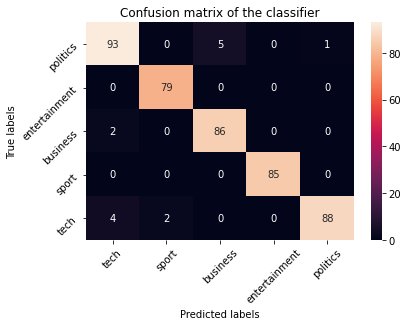

[[91  0  6  0  2]
 [ 0 77  0  0  2]
 [ 2  0 86  0  0]
 [ 0  1  0 84  0]
 [ 4  1  0  0 89]]


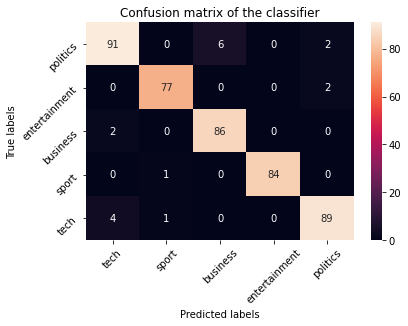

[[89  0  7  0  3]
 [ 0 76  1  0  2]
 [ 2  0 86  0  0]
 [ 0  0  0 85  0]
 [ 4  1  0  1 88]]


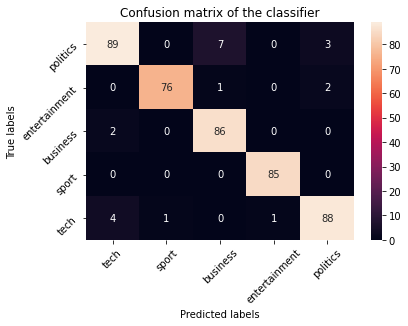

In [56]:
print('Accuracy with BOW vectors \n'+'-'*15)
print(f'Using Logistic regression : {accuracy_score(LR_prediction, y_test)}')
print(f'Using Naive Bayes : {accuracy_score(NB_prediction, y_test)}')
print(f'Using Support Vector Machines : {accuracy_score(SVM_prediction, y_test)}')
show_confusion_matrix(LR_prediction, y_test)
show_confusion_matrix(NB_prediction, y_test)
show_confusion_matrix(SVM_prediction, y_test)

### Using TFIDF vectors

In [57]:
X = X_tfidf.toarray()
y = category_onehot
print(X.shape, y.shape)

(2225, 6290) (2225,)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=9)

model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
LR_prediction = model.predict(X_test)

model = naive_bayes.MultinomialNB()
model.fit(X_train,y_train)
NB_prediction = model.predict(X_test)

model = svm.SVC()
model.fit(X_train,y_train)
SVM_prediction = model.predict(X_test)

Accuracy with TF IDF vectors 
---------------
Using Logistic regression : 0.9685393258426966
Using Naive Bayes : 0.950561797752809
Using Support Vector Machines : 0.952808988764045
[[91  0  7  0  1]
 [ 2 77  0  0  0]
 [ 1  0 87  0  0]
 [ 0  0  0 85  0]
 [ 1  1  0  1 91]]


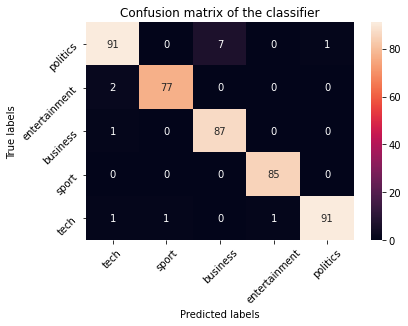

[[90  0  7  0  2]
 [ 2 74  0  0  3]
 [ 1  0 86  1  0]
 [ 0  0  0 85  0]
 [ 3  2  0  1 88]]


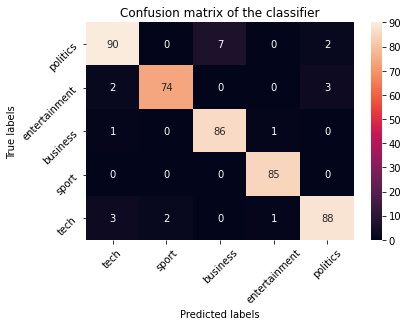

[[91  0  7  0  1]
 [ 2 77  0  0  0]
 [ 2  0 85  1  0]
 [ 0  2  0 83  0]
 [ 4  1  0  1 88]]


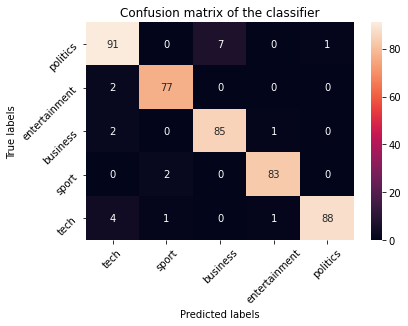

In [59]:
print('Accuracy with TF IDF vectors \n'+'-'*15)
print(f'Using Logistic regression : {accuracy_score(LR_prediction, y_test)}')
print(f'Using Naive Bayes : {accuracy_score(NB_prediction, y_test)}')
print(f'Using Support Vector Machines : {accuracy_score(SVM_prediction, y_test)}')
show_confusion_matrix(LR_prediction, y_test)
show_confusion_matrix(NB_prediction, y_test)
show_confusion_matrix(SVM_prediction, y_test)

### Using TFIDF-ngram vectors

In [60]:
X = X_ngram.toarray()
y = category_onehot
print(X.shape, y.shape)

(2225, 8019) (2225,)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=9)

model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
LR_prediction = model.predict(X_test)

model = naive_bayes.MultinomialNB()
model.fit(X_train,y_train)
NB_prediction = model.predict(X_test)

model = svm.SVC()
model.fit(X_train,y_train)
SVM_prediction = model.predict(X_test)

Accuracy with TF-IDF n-gram vectors 
---------------
Using Logistic regression : 0.9685393258426966
Using Naive Bayes : 0.950561797752809
Using Support Vector Machines : 0.9550561797752809
[[91  0  7  0  1]
 [ 2 77  0  0  0]
 [ 1  0 87  0  0]
 [ 0  0  0 85  0]
 [ 1  1  0  1 91]]


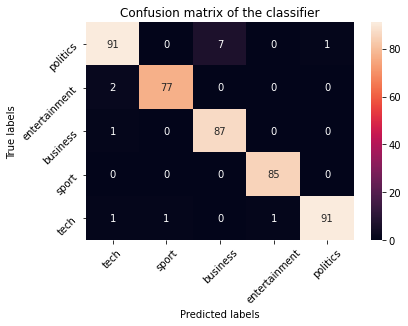

[[90  0  7  0  2]
 [ 2 74  0  0  3]
 [ 1  0 86  1  0]
 [ 0  0  0 85  0]
 [ 3  2  0  1 88]]


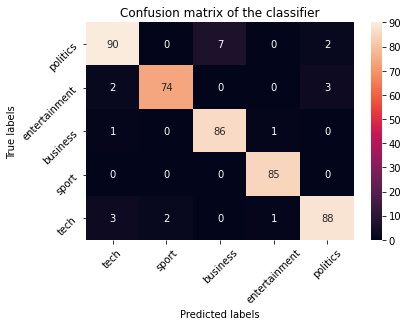

[[91  0  7  0  1]
 [ 2 77  0  0  0]
 [ 2  0 86  0  0]
 [ 0  2  0 83  0]
 [ 4  1  0  1 88]]


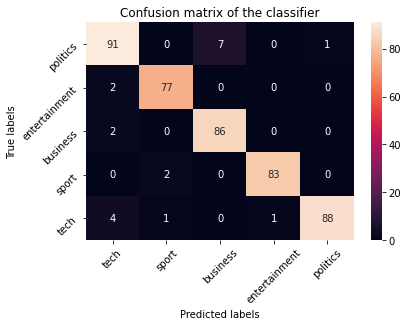

In [62]:
print('Accuracy with TF-IDF n-gram vectors \n'+'-'*15)
print(f'Using Logistic regression : {accuracy_score(LR_prediction, y_test)}')
print(f'Using Naive Bayes : {accuracy_score(NB_prediction, y_test)}')
print(f'Using Support Vector Machines : {accuracy_score(SVM_prediction, y_test)}')
show_confusion_matrix(LR_prediction, y_test)
show_confusion_matrix(NB_prediction, y_test)
show_confusion_matrix(SVM_prediction, y_test)

In [84]:
#final model

title_vectorizer = TfidfVectorizer(min_df=5)
story_vectorizer = TfidfVectorizer(min_df=10)

title_tfidf = title_vectorizer.fit_transform(processed_titles)
story_tfidf = story_vectorizer.fit_transform(processed_stories)

X_tfidf =  hstack((title_tfidf, story_tfidf))

X = X_tfidf.toarray()
y = category_onehot
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2)

final_model = linear_model.LogisticRegression()
final_model.fit(X_train,y_train)
LR_prediction = final_model.predict(X_test)

In [85]:
print('Final mode : \n'+'-'*18)
print(f'TF-IDF + Logistic regression : {accuracy_score(LR_prediction, y_test)}\n'+'*'*60)
print(classification_report(y_test ,LR_prediction, target_names=labels))

Final mode : 
------------------
TF-IDF + Logistic regression : 0.9775280898876404
************************************************************
               precision    recall  f1-score   support

         tech       0.98      0.99      0.98        83
        sport       1.00      0.90      0.95        82
     business       0.96      1.00      0.98        88
entertainment       1.00      1.00      1.00       109
     politics       0.95      0.99      0.97        83

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



[[ 82   0   0   0   1]
 [  2  74   3   0   3]
 [  0   0  88   0   0]
 [  0   0   0 109   0]
 [  0   0   1   0  82]]


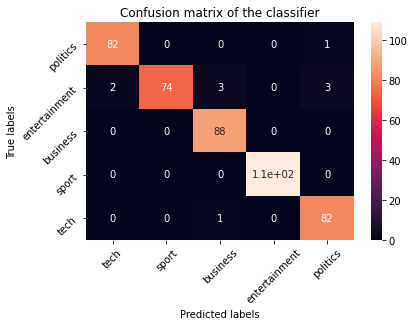

In [86]:
show_confusion_matrix(LR_prediction, y_test)